<a href="https://colab.research.google.com/github/lis-r-barreto/Data-Engineering/blob/main/03_Building_Fast_Queries_on_a_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buildling Fast Queries on a CSV (Performance Analysis)

Data utilized in this analysis is adapted from [Laptop Prices dataset on Kaggle](https://www.kaggle.com/ionaskel/laptop-prices).
<br>I will be performing time analysis of a better version of an algorithm with it's slower cousin for the following 3 case studies:
>**|2|** [Querying laptop by its ID](#query-laptop-id)
<br>**|3|** [Two-laptops promotion](#2laptops-promotion)
<br>**|4|** [What laptops favor the budget?](#within-budget)

## All imports

In [ ]:
import csv
import chardet
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline


## Determine file encoding

In [ ]:
file = "laptops.csv"
encoding = ""

with open(file, mode="rb") as file:
    raw_bytes = file.read()
    encoding = chardet.detect(raw_bytes)['encoding']

print(encoding)

utf-8


## Familiarize with Inventory

In [ ]:
with open("laptops.csv", encoding=encoding, mode="r") as file:
    file_reader = csv.reader(file)
    laptops = list(file_reader)

header = laptops[0]
rows = laptops[1:]

print(header)
pd.DataFrame(rows[:4])

['Id', 'Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price']


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,6571244,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339
1,7287764,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898
2,3362737,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575
3,9722156,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537


## De-allocate modules no longer necessary

In [ ]:
del pd

<br><br>

# Inventory Class for all your needs

## |1| Detect encoding + Read inventory

In [ ]:
# v0.0
class Inventory():
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]
        
        for row in self.rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])

    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']


### TEST |1| Count inventory

In [ ]:
# v0.0 TEST
laptops = Inventory("laptops.csv")
len(laptops.rows)

1303

<br>
<br>The very first thing that I want to start off with is querying the laptop by its ID.
<br>Seems straight-forward, until its time performance is measured.

<h2 id="query-laptop-id"> |2a| Query inventory by ID </h2>
<br>Here's a simple way to query the laptop inventory by its ID by scanning the python list:

In [ ]:
# v0.1
class Inventory():
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]
        
        for row in rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])

    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']

    # Query inventory by ID
    def get_laptop_from_id(self, laptop_id):
        for row in self.rows:
            if row[0] == laptop_id:
                return row
        return None


### TEST |2a| Query inventory by ID

Test if everything works as expected.

In [ ]:
# v0.1 TEST
laptops = Inventory("laptops.csv")

test_laptop_id = "3362737"
print(f"ID {test_laptop_id} Found -> ", laptops.get_laptop_from_id(test_laptop_id))
print()

test_laptop_id = "3362736"
print(f"ID {test_laptop_id} Found -> ", laptops.get_laptop_from_id(test_laptop_id))
print()


ID 3362737 Found ->  ['3362737', 'HP', '250 G6', 'Notebook', '15.6', 'Full HD 1920x1080', 'Intel Core i5 7200U 2.5GHz', '8GB', '256GB SSD', 'Intel HD Graphics 620', 'No OS', '1.86kg', '575']

ID 3362736 Found ->  None



<br>

## |2b| Query inventory by ID Fast!
A faster version of the same task that uses python dictionary:

In [ ]:
# v0.2
class Inventory():
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]

        for row in self.rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])
        self.id_to_row = {row[0]:row for row in self.rows}  # Fast fetch with dict!


    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']


    # Query inventory by ID
    def get_laptop_from_id(self, laptop_id):  # O(N)
        for row in self.rows:                 # O(N)
            if row[0] == laptop_id:           # O(N)
                return row                    # 1
        return None                           # 1


    # Query inventory by ID fast!
    def get_laptop_from_id_fast(self, laptop_id):  # O(1)
        return self.id_to_row[laptop_id] if laptop_id in self.id_to_row else None  # 1


    # Visual Modeling Time Complexity
    def plot(self, fig, values, label, color):
        plt.plot(values, label=label, figure=fig, color=color)
        plt.xlabel("N values")
        plt.ylabel("Precious Time (s)")
        ax = fig.axes[0]
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


### TEST |2b| Query inventory by ID, Fast!

Test if everything works as expected.

In [ ]:
# v0.2 TEST
laptops = Inventory("laptops.csv")

test_laptop_id = "3362737"
print(f"ID {test_laptop_id} Found -> ", laptops.get_laptop_from_id_fast(test_laptop_id))
print()

test_laptop_id = "3362736"
print(f"ID {test_laptop_id} Found -> ", laptops.get_laptop_from_id_fast(test_laptop_id))
print()


ID 3362737 Found ->  ['3362737', 'HP', '250 G6', 'Notebook', '15.6', 'Full HD 1920x1080', 'Intel Core i5 7200U 2.5GHz', '8GB', '256GB SSD', 'Intel HD Graphics 620', 'No OS', '1.86kg', 575]

ID 3362736 Found ->  None



<br>

## |2a vs 2b| Performance Test

Here I will compare the Time complexities of the two fetching methods **`get_laptop_from_id()`** and **`get_laptop_from_id_fast()`** by ***simulating with higher volume of data (about 10 times)*** than the input file.

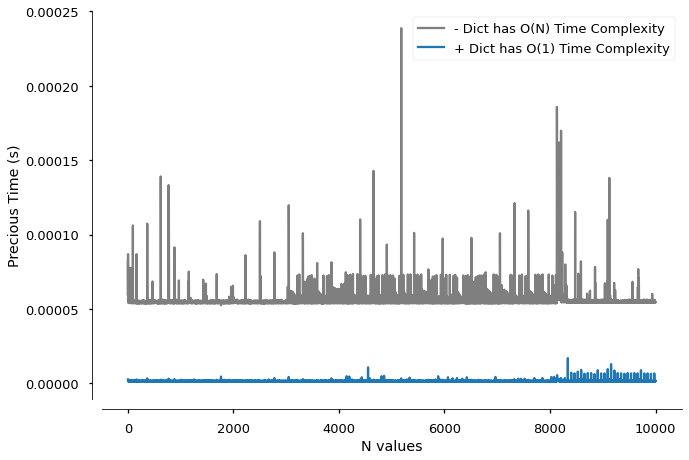

In [ ]:
# v0.2 Time Complexity

ids = [str(random.randint(1_000_000, 9_999_999)) for r in range(10_000)]

laptops = Inventory("laptops.csv")

total_time_no_dict = []
total_time_dict = []

for id in ids:
    start = time.time()
    laptops.get_laptop_from_id(id)
    end = time.time()
    total_time_no_dict.append(end-start)
    
    start = time.time()
    laptops.get_laptop_from_id_fast(id)
    end = time.time()
    total_time_dict.append(end-start)


plt.style.use("seaborn-talk")
fig = plt.figure()
laptops.plot(fig, total_time_no_dict, "- Dict has O(N) Time Complexity", "tab:gray")
laptops.plot(fig, total_time_dict, "+ Dict has O(1) Time Complexity", "tab:blue")
plt.legend()
plt.show()

As you can see, the (without dictionary) `- Dict` line has **O(N) Time Complexity** where N is the number of rows of data from the input file.

The (with dictionary) `+ Dict` line has **O(1) Constant-Time Complexity** that's attributed to the use of dictionary that aids in fast querying.
<br>
<br>

### Analysis
The dictionary version of query fetch is at least **x30 faster!**

In [ ]:
sum(total_time_no_dict)/sum(total_time_dict)

37.66611473653453

<br><br>

<h2 id="2laptops-promotion"> |3| Two-Laptops Promotion </h2>

Now let's consider a scenario where the store offers a promotion to certain customers:

1. By way of a $2,500 value gift card.

2. It's a one-time use gift card whose balance, if any, will be waived!

3. The inventory has only three laptops valued at dollars 1339, 898 and 575.

4. And, the customer can buy upto 2 laptops.

If I was the customer, I would want to buy 2 laptops with the gift card. The maximum I can spend with the available inventory is 2237 (1339 + 898).
<br>
If it was you, would you forego the balance? I wouldn't.
<br>
So, given the amount, here's a function that checks if it's possible to spend all of gift-card value leaving no balance favoring 2 laptops purchase:
<br>


## |3a| Check all of inventory for the laptop combo, looping twice!

In [ ]:
# v0.3
class Inventory():
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]
        
        for row in self.rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])
        self.id_to_row = {row[0]:row for row in self.rows}  # Fast fetch with dict!


    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']


    # Query inventory by ID
    def get_laptop_from_id(self, laptop_id):  # O(N)
        for row in self.rows:                 # O(N)
            if row[0] == laptop_id:           # O(N)
                return row                    # 1
        return None                           # 1


    # Query inventory by ID fast!
    def get_laptop_from_id_fast(self, laptop_id):  # O(1)
        return self.id_to_row[laptop_id] if laptop_id in self.id_to_row else None  # 1


    # Visual Modeling Time Complexity
    def plot(self, fig, values, label, color):
        plt.plot(values, label=label, figure=fig, color=color)
        plt.xlabel("N values")
        plt.ylabel("Precious Time (s)")
        ax = fig.axes[0]
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


    # Two-laptops promotion
    # Check all of inventory for the laptop combo, looping twice!
    def check_promotion_dollars(self, dollars):  # O(N^2)
        for row in self.rows:                    # O(N)
            if row[-1] == dollars:               # O(N)
                return True                      # 1
        for row in self.rows:                    # O(N)
            for r in self.rows:                  # O(N^2)
                if r[-1]+row[-1] == dollars:     # O(N^2)
                    return True                  # 1
        return False                             # 1


### TEST |3a| Two-laptops promotion

Test if everything works as expected.

In [ ]:
# v0.3 TEST
laptops = Inventory("laptops.csv")

# True for the given dataset
gift_card_value = 1000
print(f"${gift_card_value:,} gift card promotion benefit possible? ",
      laptops.check_promotion_dollars(gift_card_value))

# False for the given dataset (Worst-case scenario)
gift_card_value = 442
print(f"${gift_card_value:,} gift card promotion benefit possible? ", 
      laptops.check_promotion_dollars(gift_card_value))


$1,000 gift card promotion benefit possible?  True
$442 gift card promotion benefit possible?  False


<br>
Thinking about looping twice certainly made me restless. This amounts to Quadratic Time Complexity. There is always a better way to do things. Let's tweak this solution and come up with a faster way to detect the combo.
<br><br>

## |3b| Check all of inventory for the laptop combo, fast!
Here, I use `set()`; a simple and quick check is all i need.

In [ ]:
# v0.4
class Inventory():
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]

        for row in self.rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])
        self.id_to_row = {row[0]:row for row in self.rows}  # Fast fetch with dict!
        self.prices = set(row[-1] for row in self.rows)  # Fast detect price with set()

    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']

    # Query inventory by ID
    def get_laptop_from_id(self, laptop_id):  # O(N)
        for row in self.rows:                 # O(N)
            if row[0] == laptop_id:           # O(N)
                return row                    # 1
        return None                           # 1


    # Query inventory by ID fast!
    def get_laptop_from_id_fast(self, laptop_id):  # O(1)
        return self.id_to_row[laptop_id] if laptop_id in self.id_to_row else None  # 1


    # Visual Modeling Time Complexity
    def plot(self, fig, values, label, color):
        plt.plot(values, label=label, figure=fig, color=color)
        plt.xlabel("N values")
        plt.ylabel("Precious Time (s)")
        ax = fig.axes[0]
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


    # Two-laptops promotion
    # Check all of inventory for the laptop combo, looping twice!
    def check_promotion_dollars(self, dollars):  # O(N^2)
        for row in self.rows:                    # O(N)
            if row[-1] == dollars:               # O(N)
                return True                      # 1
        for row in self.rows:                    # O(N)
            for r in self.rows:                  # O(N^2)
                if r[-1]+row[-1] == dollars:     # O(N^2)
                    return True                  # 1
        return False                             # 1


    # Two-laptops promotion
    # Check all of inventory for the laptop combo, fast!
    def check_promotion_dollars_fast(self, dollars):  # O(N)
        if dollars in self.prices:                    # 1
            return True                               # 1
        for price in self.prices:                     # O(N)
            if dollars-price in self.prices:          # O(N)
                return True                           # 1
        return False                                  # 1


### TEST |3b| Two-laptops promotion

Test if everything works as expected.

In [ ]:
# v0.4 TEST
laptops = Inventory("laptops.csv")

# True for the given dataset
gift_card_value = 1000
print(f"${gift_card_value:,} gift card promotion benefit possible? ",
      laptops.check_promotion_dollars_fast(gift_card_value))

# False for the given dataset (Worst-case scenario)
gift_card_value = 442
print(f"${gift_card_value:,} gift card promotion benefit possible? ",
      laptops.check_promotion_dollars_fast(gift_card_value))


$1,000 gift card promotion benefit possible?  True
$442 gift card promotion benefit possible?  False


<br>

## |3a vs 3b| Performance Test

Here I will compare the Time complexities of the two querying methods **`check_promotion_dollars()`** and **`check_promotion_dollars_fast()`** by ***simulating with 5 times more data*** than the input file.

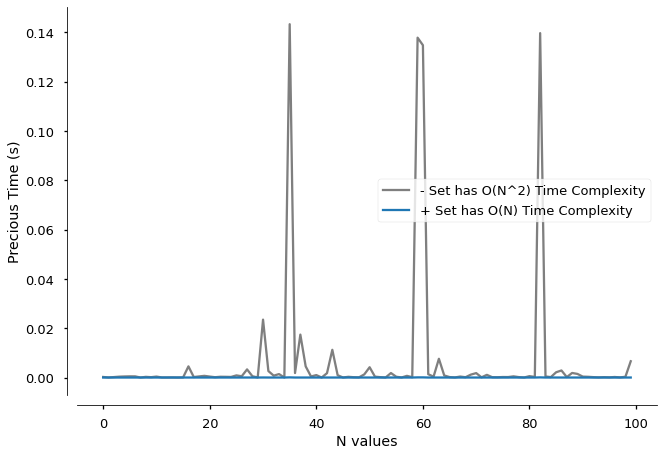

In [ ]:
# v0.4 Time Complexity

prices = [random.randint(100, 5_000) for r in range(100)]
laptops = Inventory("laptops.csv")

total_time_no_set = []
total_time_set = []

for price in prices:
    start = time.time()
    laptops.check_promotion_dollars(price)
    end = time.time()
    total_time_no_set.append(end-start)
    
    start = time.time()
    laptops.check_promotion_dollars_fast(price)
    end = time.time()
    total_time_set.append(end-start)

plt.style.use("seaborn-talk")
fig = plt.figure()
laptops.plot(fig, total_time_no_set, "- Set has O(N^2) Time Complexity", "tab:gray")
laptops.plot(fig, total_time_set, "+ Set has O(N) Time Complexity", "tab:blue")
plt.legend()
plt.show()

The time-line for the faster query looks flat (almost constant time) on a shared plot.
<br>
To see the minor variations, here's the plot:

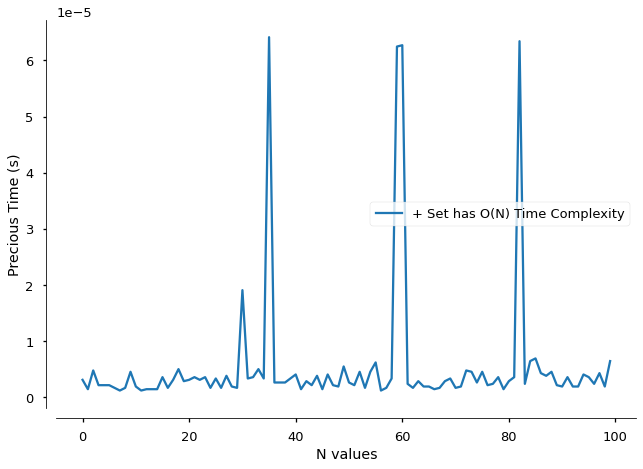

In [ ]:
# v0.4 Time Complexity

plt.style.use("seaborn-talk")
fig = plt.figure()
laptops.plot(fig, total_time_set, "+ Set has O(N) Time Complexity", "tab:blue")
plt.legend()
plt.show()

<br>

### Analysis
It's certainly not constant, but linear. But the **performance gain is at least x1000!**
<br>See below:

In [ ]:
sum(total_time_no_set)/sum(total_time_set)

1241.4249783174328

<br><br>

<h2 id="within-budget"> |4| Laptops with-in budget </h2>

Now let's say I want to know what laptops are available that are lesser than a target price (my max budget). A laptop with the target price may exist or not. If it doesn't, I have to find all laptops whose price is at most the `target price`, for which I have to **query for the first laptop whose price is more than my `target price`** if the exact target price doesn't exist in the inventory.
<br><br>One efficient strategy to enable this is to sort the inventory by price (**a O(N) time price to pay**) to find the index of the first laptop that is at most the target price.

In [ ]:
# v0.5
class Inventory():
    
    def __init__(self, csv_filename):
        self.encoding = self.detect_encoding(csv_filename)
        with open(csv_filename, encoding=self.encoding, mode="r") as file:
            file_reader = csv.reader(file)
            laptops = list(file_reader)

        self.header = laptops[0]
        self.rows = laptops[1:]

        for row in self.rows: # Convert str(price) -> int(price)
            row[-1] = int(row[-1])
        self.id_to_row = {row[0]:row for row in self.rows}  # Fast fetch with dict!
        self.prices = set(row[-1] for row in self.rows)  # Fast detect price with set()!
        self.rows_by_price = sorted(self.rows, key=lambda row: row[-1])  # Sorted price for quick fetch! O(N)

        
    def detect_encoding(self, csv_filename):
        with open(csv_filename, mode="rb") as file:
            raw_bytes = file.read()
        return chardet.detect(raw_bytes)['encoding']

    
    # Query inventory by ID
    def get_laptop_from_id(self, laptop_id):  # O(N)
        for row in self.rows:                 # O(N)
            if row[0] == laptop_id:           # O(N)
                return row                    # 1
        return None                           # 1


    # Query inventory by ID fast!
    def get_laptop_from_id_fast(self, laptop_id):  # O(1)
        return self.id_to_row[laptop_id] if laptop_id in self.id_to_row else None  # 1


    # Visual Modeling Time Complexity
    def plot(self, fig, values, label, color):
        plt.plot(values, label=label, figure=fig, color=color)
        plt.xlabel("N values")
        plt.ylabel("Precious Time (s)")
        ax = fig.axes[0]
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


    # Two-laptops promotion
    # Check all of inventory for the laptop combo, looping twice!
    def check_promotion_dollars(self, dollars):  # O(N^2)
        for row in self.rows:                    # O(N)
            if row[-1] == dollars:               # O(N)
                return True                      # 1
        for row in self.rows:                    # O(N)
            for r in self.rows:                  # O(N^2)
                if r[-1]+row[-1] == dollars:     # O(N^2)
                    return True                  # 1
        return False                             # 1


    # Two-laptops promotion
    # Check all of inventory for the laptop combo, fast!
    def check_promotion_dollars_fast(self, dollars):  # O(N)
        if dollars in self.prices:                    # 1
            return True                               # 1
        for price in self.prices:                     # O(N)
            if dollars-price in self.prices:          # O(N)
                return True                           # 1
        return False                                  # 1
    
    
    # Binary Search: O(log(N))
    def find_first_laptop_more_expensive(self, target_price):
        range_start = 0
        range_end = len(self.rows_by_price) - 1
        while range_start < range_end:
            range_middle = (range_start + range_end) // 2  # O(log(N)) as search space is halved each iteration.
            price = self.rows_by_price[range_middle][-1]
            if price <= target_price:
                range_start = range_middle + 1
            else:
                range_end = range_middle

        if self.rows_by_price[range_start][-1] <= target_price:
            return -1
        return range_start


### TEST |4| Laptops with-in budget

In [ ]:
# v0.5 TEST
laptops = Inventory("laptops.csv")

# True for the given dataset
target_price = 1_000
print(f"Target price (budget={target_price:,});",
      ("All with-in budget!"
          if (i:=laptops.find_first_laptop_more_expensive(target_price)) == -1 
          else "".join(["Index at ", str(i)])))

# False for the given dataset (Worst-case scenario)
target_price = 10_000
print(f"Target price (budget={target_price:,});",
      ("All with-in budget!"
          if (i:=laptops.find_first_laptop_more_expensive(target_price)) == -1 
          else "".join(["Index at ", str(i)])))


Target price (budget=1,000); Index at 683
Target price (budget=10,000); All with-in budget!


### Analysis
The overall time complexity for this search termed **Binary Search is O(N)**.
<br>This is because, ***O(N) for the price sorting** + **O(log(N)) for the Binary Search*** yeilds **O(N + log(N))** Time.
<br>Aligning this with Algorithm Time modeling terms, the most significant term is O(N) and the lesser significant term is O(log(N)).
<br>We go with only the most significant term, O(N).

# Conclusion
A faster algorithm that finds the right balance between Time and Space complexities is worth the time investment especially where search is involved.
<br>**A stitch in time saves nine!**
<br>There's more to build depending on the business need. For now, it's the above three.
